In [1]:
import torch, pickle
from torch.utils.data import Dataset, DataLoader
from utils.PreProc_Data.DataProc import StackedSequenceDataset
import numpy as np
from MZA_Experiment import MZA_Experiment
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
exp_dir   = "Trained_Models"  #Experiment Directory
exp_name  = "sl64_nhu40_nl1_bs16_2"             #One of the experiment names
args = pickle.load(open(exp_dir + "/" + exp_name + "/args","rb"))
mza = MZA_Experiment(args)

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.



In [3]:
mza.__dict__

{'device': device(type='cuda'),
 'train_size': 0.8,
 'batch_size': 16,
 'ntransients': 100,
 'seq_len': 64,
 'num_obs': 64,
 'num_layers': 1,
 'num_hidden_units': 40,
 'learning_rate': 0.0001,
 'nepochs': 100,
 'norm_input': False,
 'nsave': 10,
 'info': '2',
 'exp_dir': 'Trained_Models',
 'exp_name': 'sl64_nhu40_nl1_bs16_2',
 'data_dir': 'Data/Duffing/duffing.npy',
 'no_save_model': True,
 'args': Namespace(coupled=False, lr=0.0001, nepochs=100, nlayers=1, nhu=40, seq_len=64, num_obs=64, ntransients=100, bs=16, train_size=0.8, norm_input=False, exp_dir='Trained_Models', data_dir='Data/Duffing/duffing.npy', nsave=10, no_save_model=True, info='2'),
 'lp_data': array([[[-2.        , -2.        ],
         [-2.19050195, -0.99347687],
         [-2.24400724,  0.14547107],
         ...,
         [ 0.98808839, -0.06949171],
         [ 0.9798476 , -0.06142027],
         [ 0.97270511, -0.05207581]],
 
        [[-2.        , -1.8       ],
         [-2.16692078, -0.82445269],
         [-2.2030091

In [4]:
mza.model

MZANetwork(
  (autoencoder): Autoencoder(
    (encoder): Sequential(
      (0): Linear(in_features=2, out_features=100, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=100, out_features=100, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=100, out_features=64, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=64, out_features=100, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=100, out_features=100, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=100, out_features=2, bias=True)
    )
  )
  (koopman): Koopman()
  (seqmodel): LSTM_Model(
    (lstm): LSTM(64, 40, batch_first=True)
    (fc_1): Linear(in_features=40, out_features=128, bias=True)
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc_2): Linear(in_features=128, out_features=64, bias=True)
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [5]:
dataset = mza.test_dataset
num_trajs = mza.test_num_trajs
predict_dataloader = DataLoader(dataset, batch_size = len(dataset), shuffle = False)
print(len(predict_dataloader))
len(dataset)


1


10680

In [6]:
it = iter(predict_dataloader)
Phi_seq, Phi_nn = next(it)
print(Phi_seq.shape, Phi_nn.shape)

re_Phi_seq = Phi_seq.reshape(int(Phi_seq.shape[0]/num_trajs), num_trajs, *Phi_seq.shape[1:])
re_Phi_nn  = Phi_nn.reshape(int(Phi_nn.shape[0]/num_trajs), num_trajs, *Phi_nn.shape[1:])

print(re_Phi_seq.shape, re_Phi_nn.shape)

torch.Size([10680, 64, 2]) torch.Size([10680, 2])
torch.Size([120, 89, 64, 2]) torch.Size([120, 89, 2])


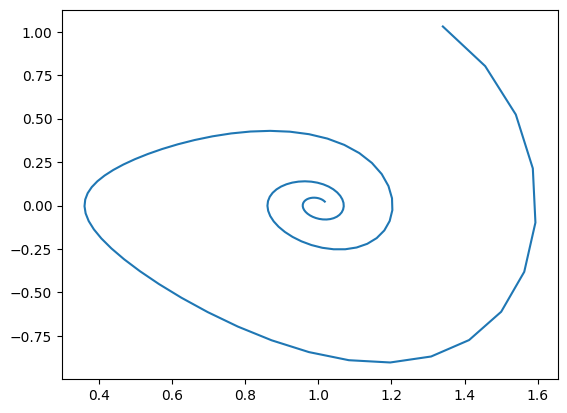

In [7]:
plt.plot(re_Phi_nn.cpu().numpy()[:,0,0], re_Phi_nn.cpu().numpy()[:,0,1])

In [8]:
PATH = mza.exp_dir+'/'+ mza.exp_name+"/model_weights/at_epoch{epoch}".format(epoch=80)
mza.model.load_state_dict(torch.load(PATH))
x_nn_hat, Phi_nn_hat = mza.predict_onestep(predict_dataloader)


/home/pg221/anaconda3/envs/KS/lib/python3.10/site-packages/torch/nn/modules/rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /opt/conda/conda-bld/pytorch_1670525552843/work/aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


In [9]:
print(Phi_nn_hat.shape)
re_Phi_nn_hat  = Phi_nn_hat.reshape(int(Phi_nn_hat.shape[0]/num_trajs), num_trajs, *Phi_nn_hat.shape[1:])
print(re_Phi_nn_hat.shape)

torch.Size([10680, 2])
torch.Size([120, 89, 2])


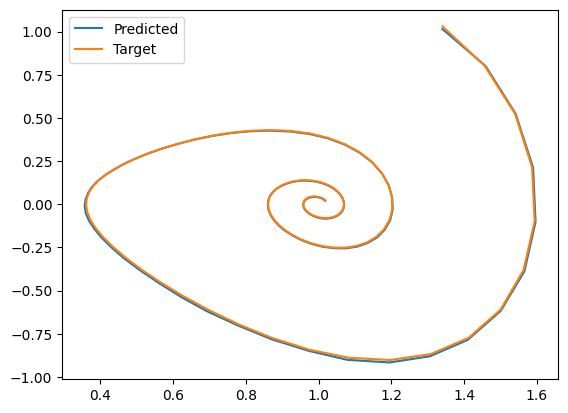

In [10]:
for i in range (1):
    plt.figure()
    plt.plot(re_Phi_nn_hat.detach().cpu().numpy()[:,i,0], re_Phi_nn_hat.detach().cpu().numpy()[:,i,1], label = "Predicted")
    plt.plot(re_Phi_nn.cpu().numpy()[:,i,0], re_Phi_nn.cpu().numpy()[:,i,1], label = "Target")
    plt.legend()

In [14]:
#multistep prediction
timesteps = 120
initial_conditions = re_Phi_nn[0]
x_hat, Phi_hat = mza.predict_multistep(initial_conditions, timesteps)

print(x_hat.shape, Phi_hat.shape)


torch.Size([89, 121, 64]) torch.Size([89, 121, 2])


/tmp/ipykernel_8170/1339801214.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


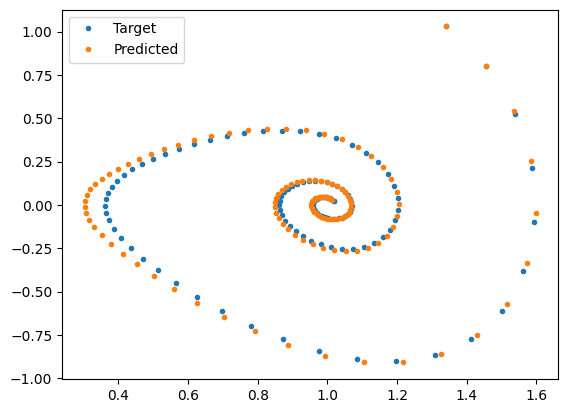

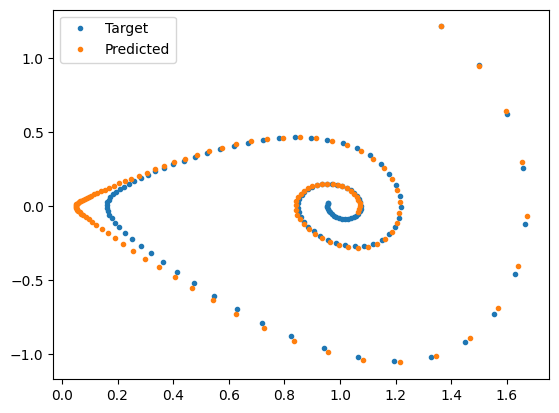

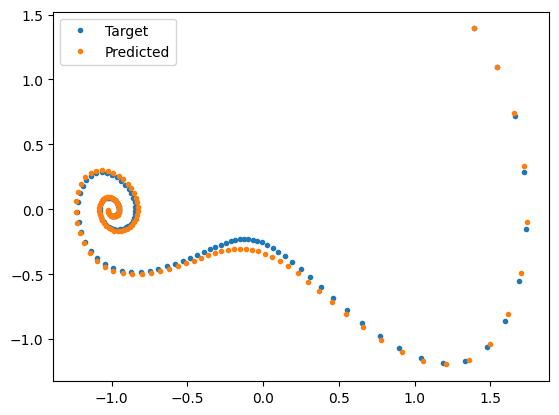

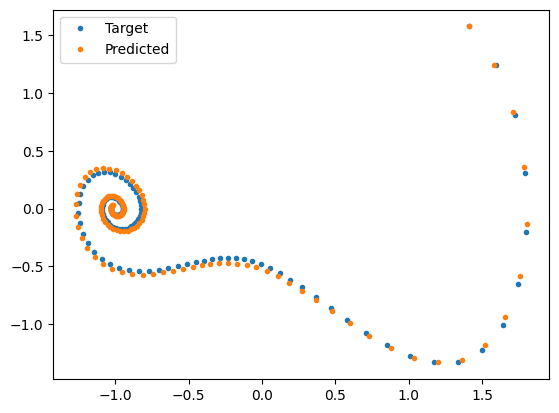

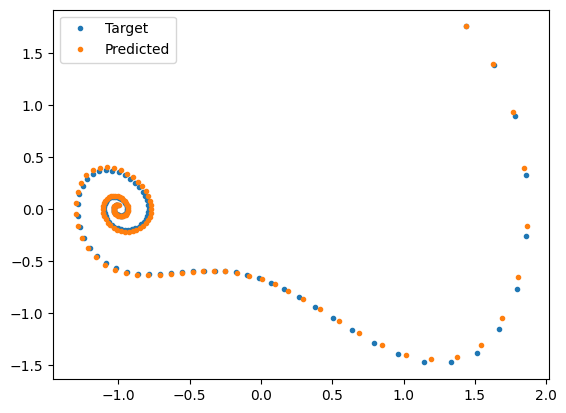

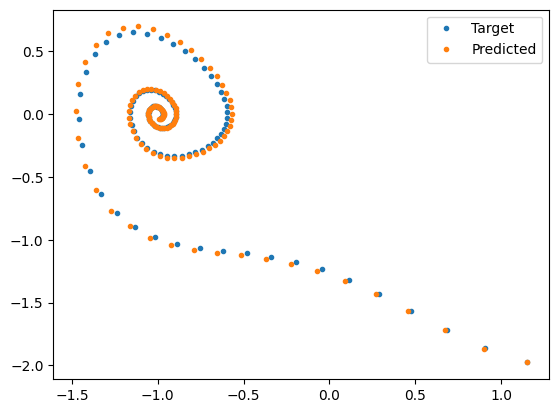

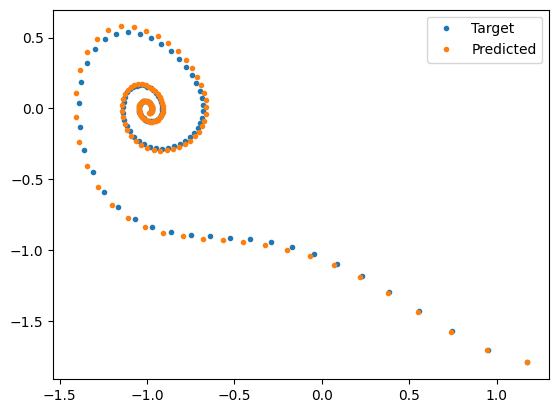

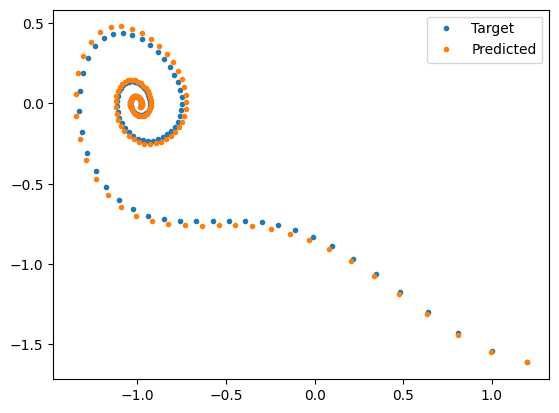

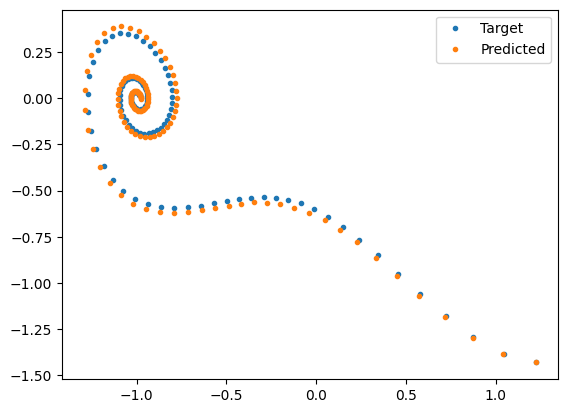

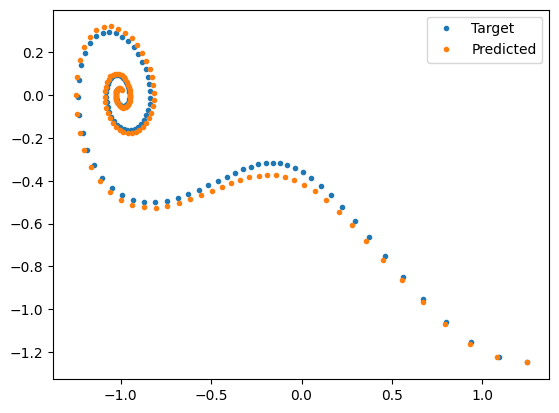

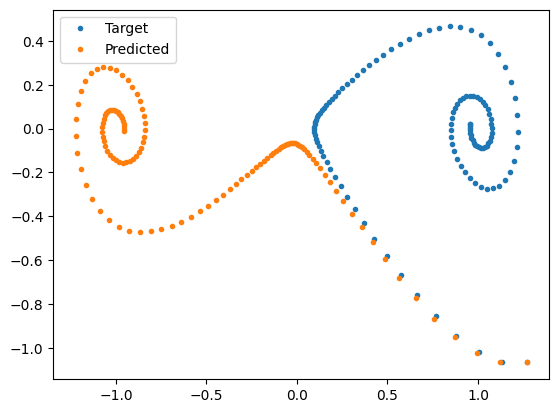

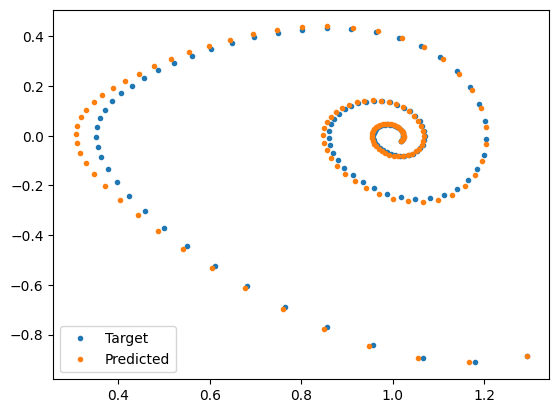

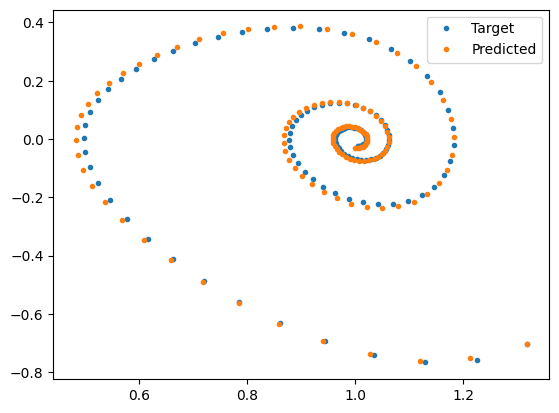

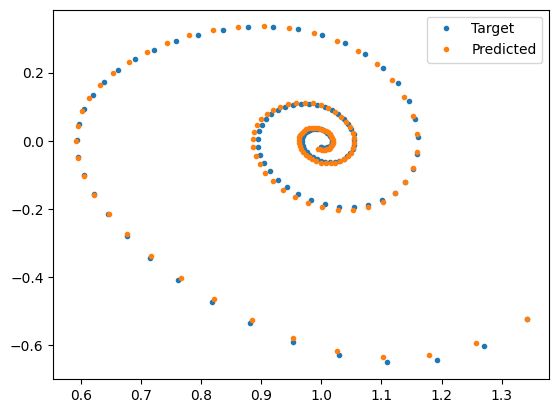

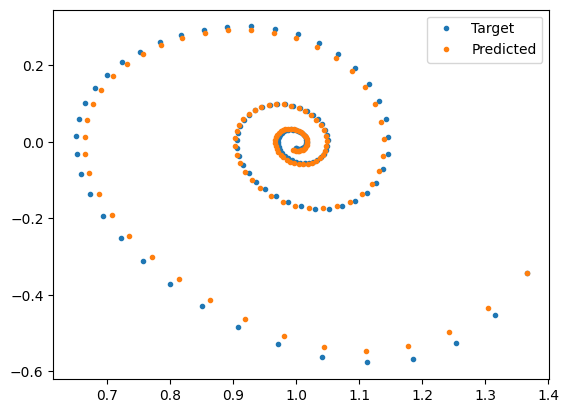

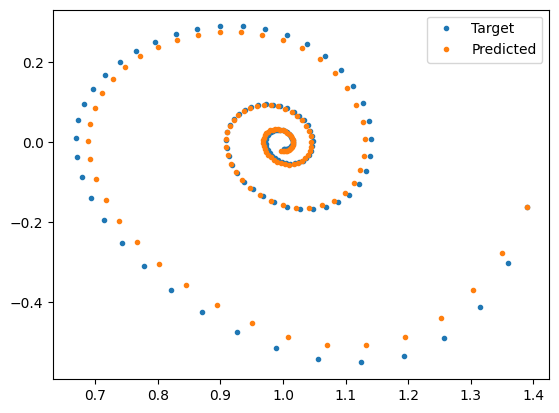

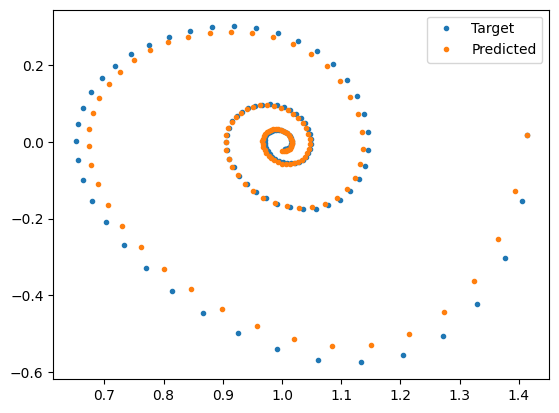

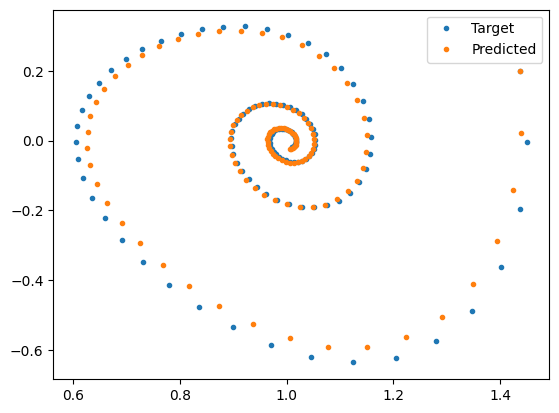

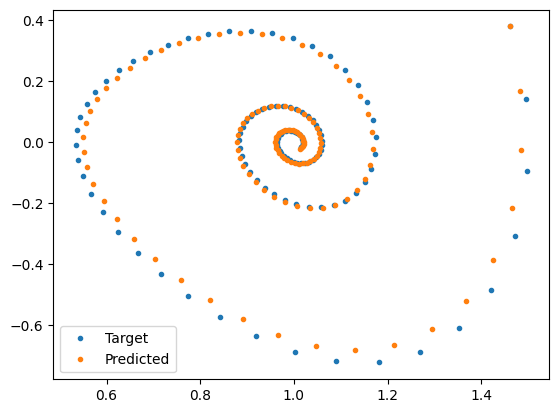

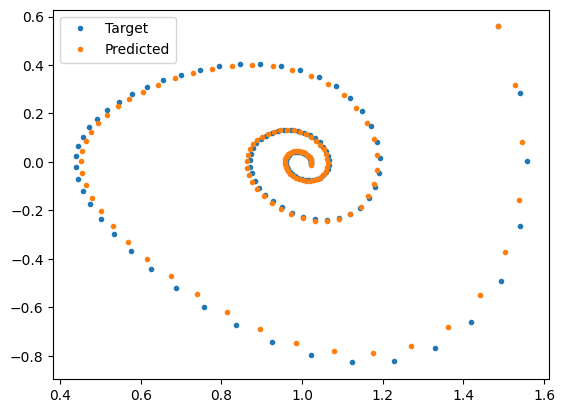

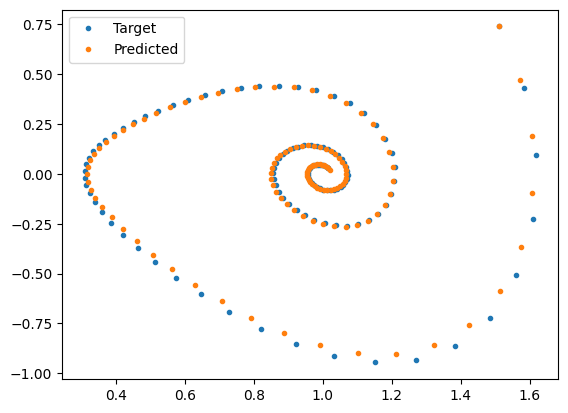

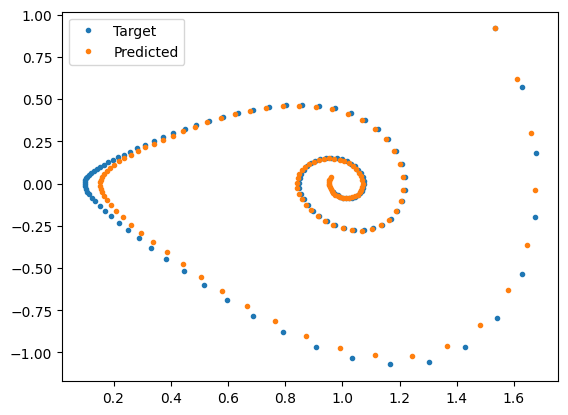

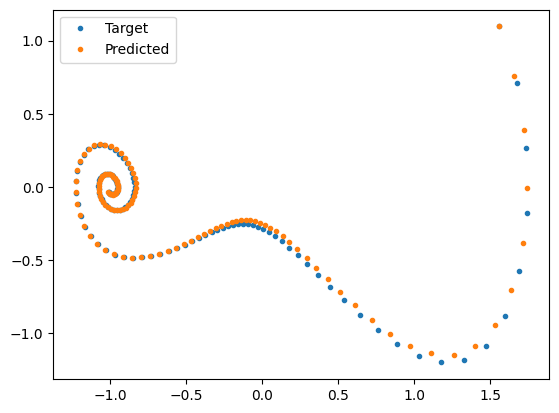

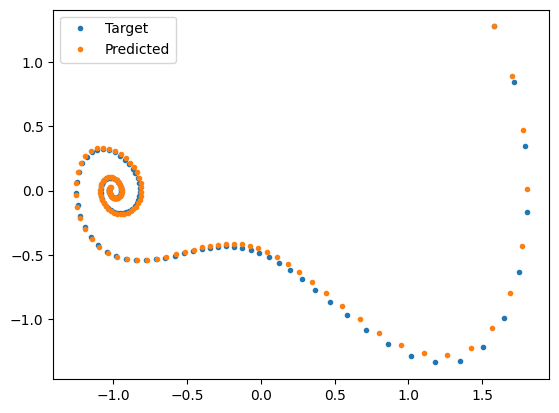

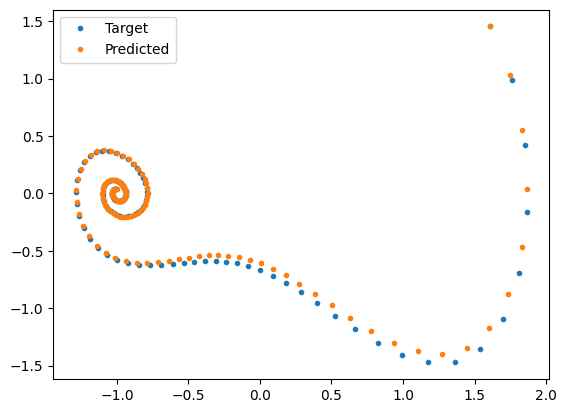

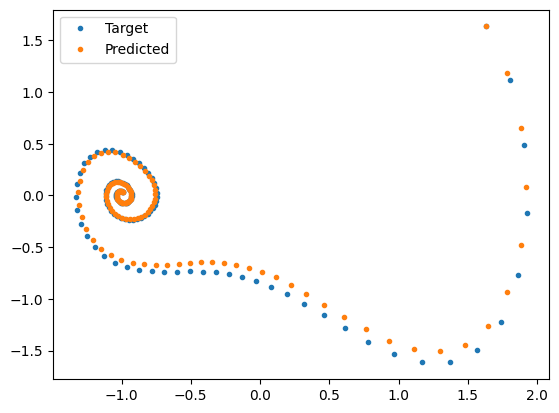

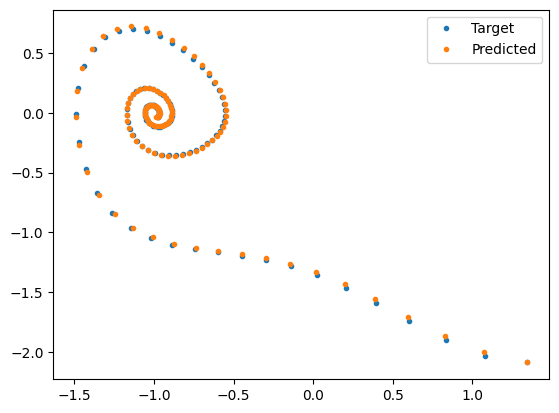

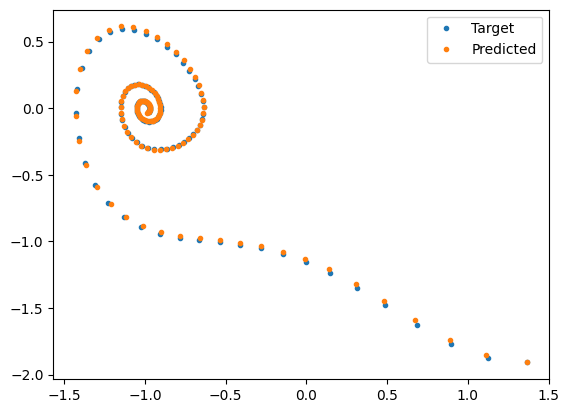

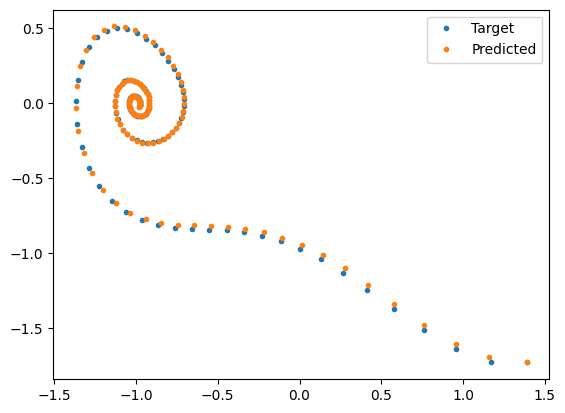

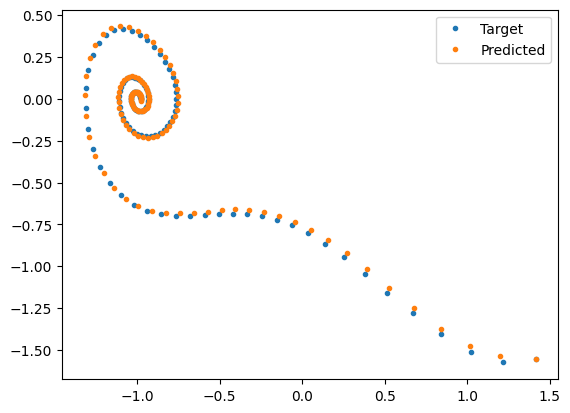

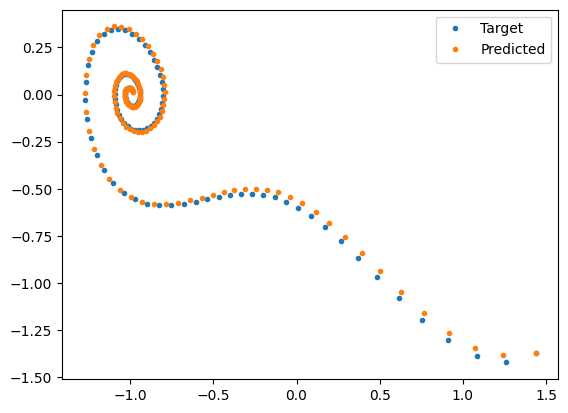

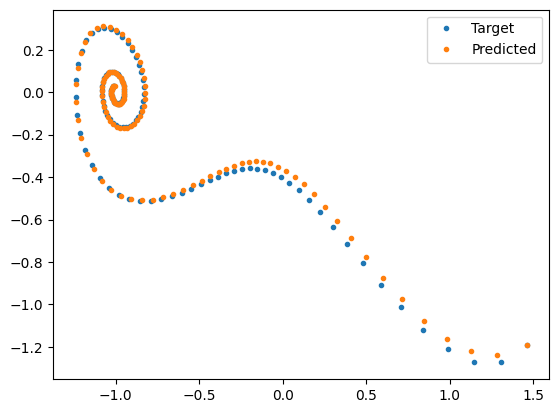

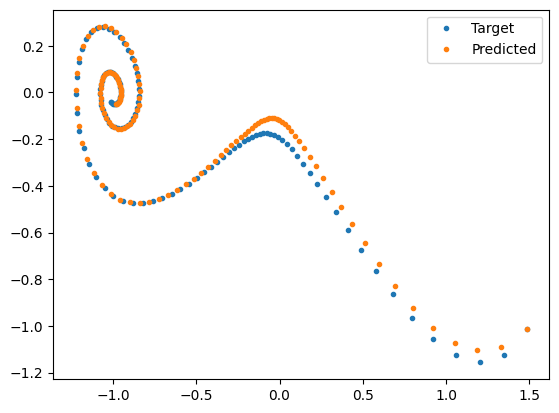

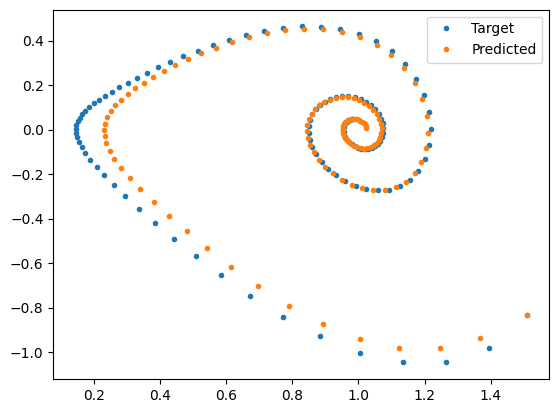

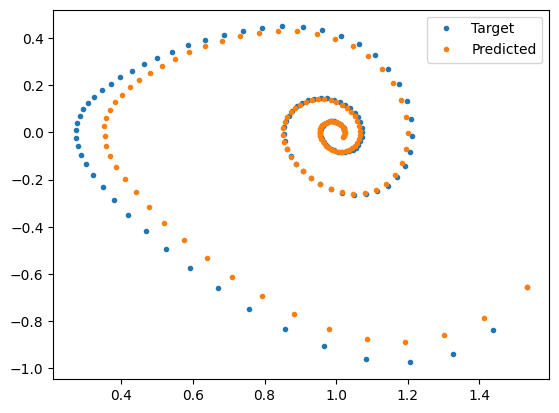

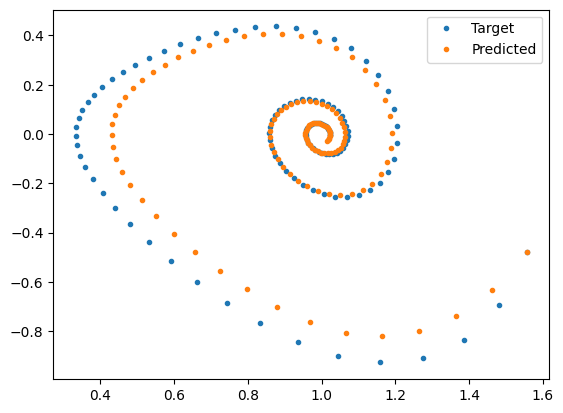

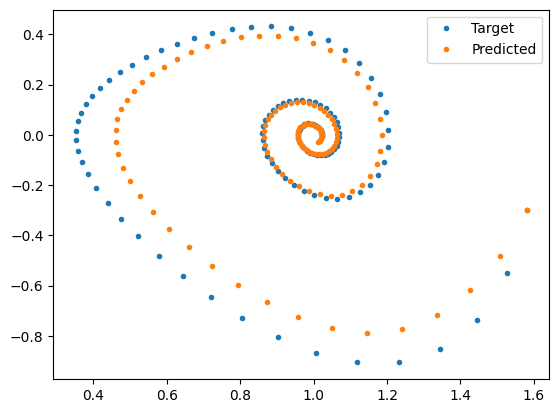

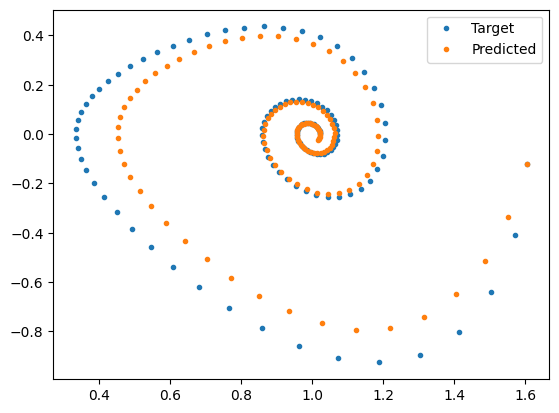

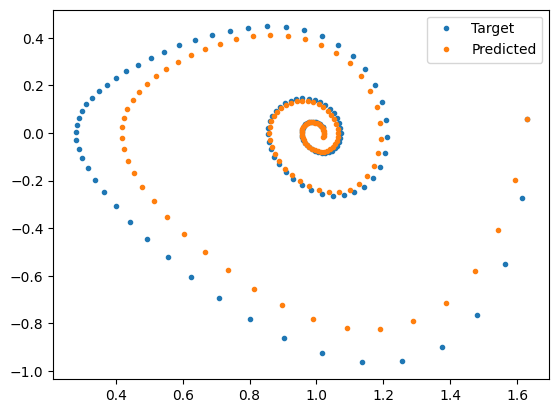

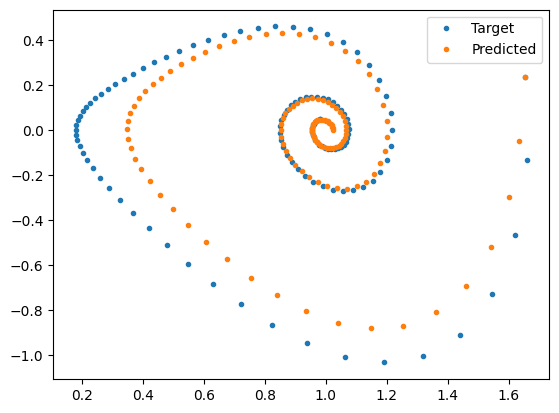

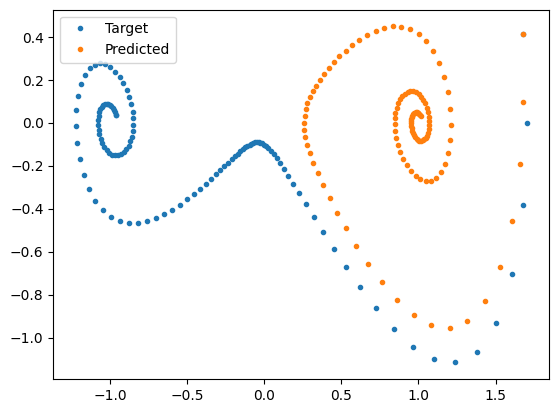

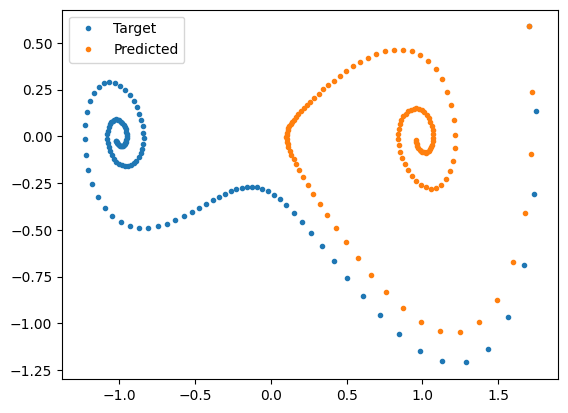

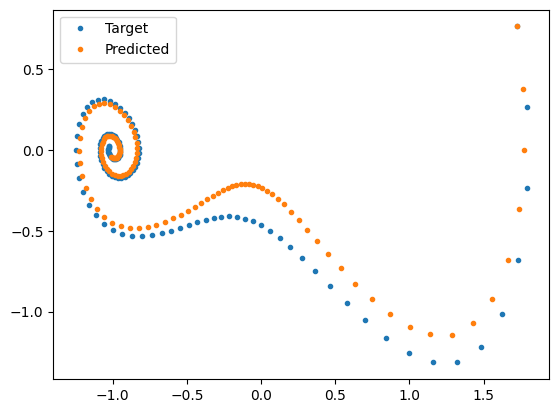

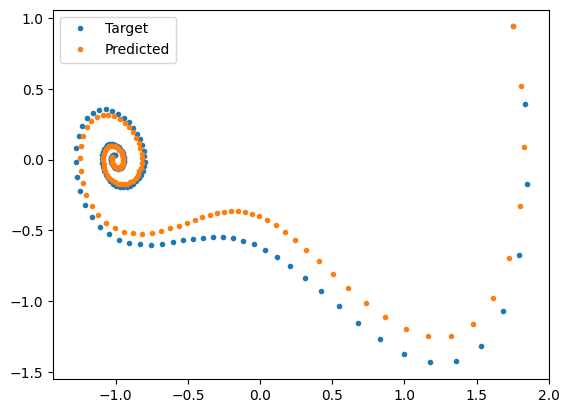

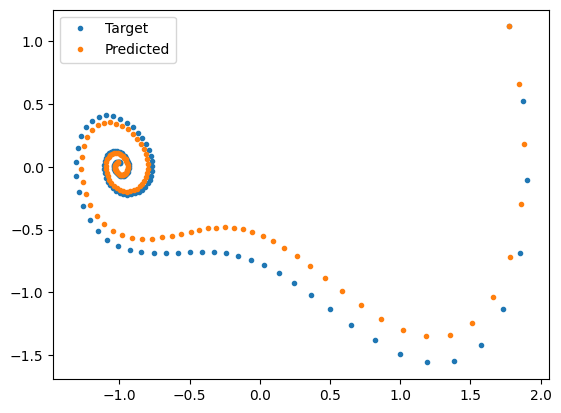

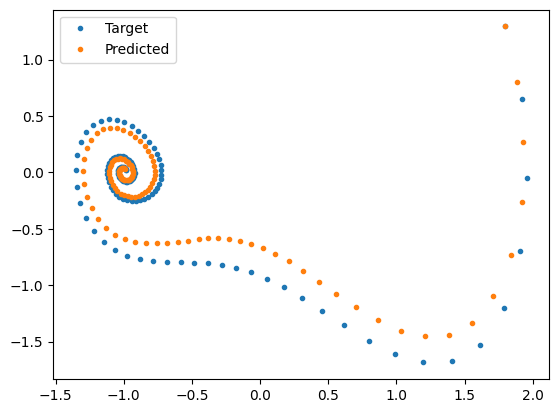

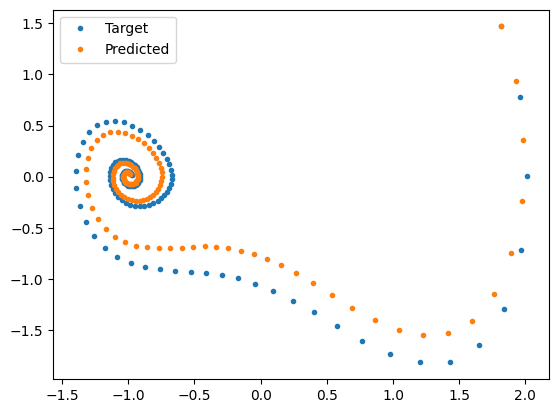

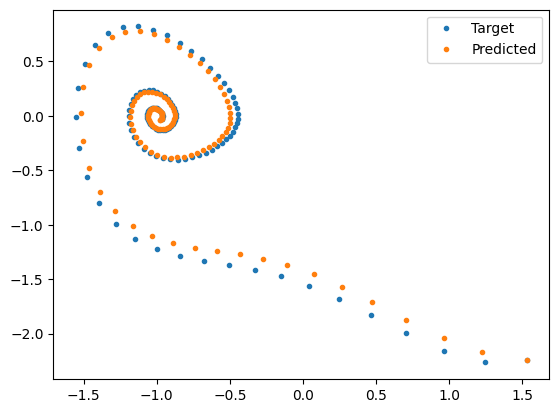

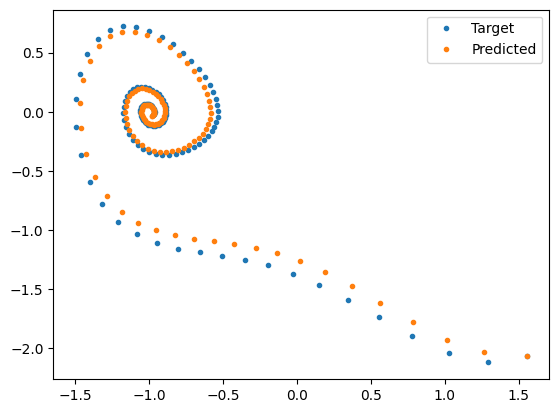

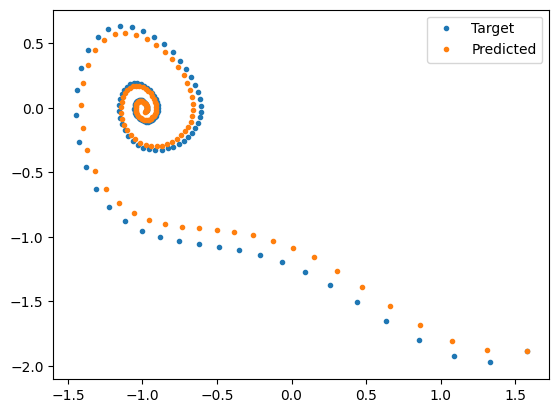

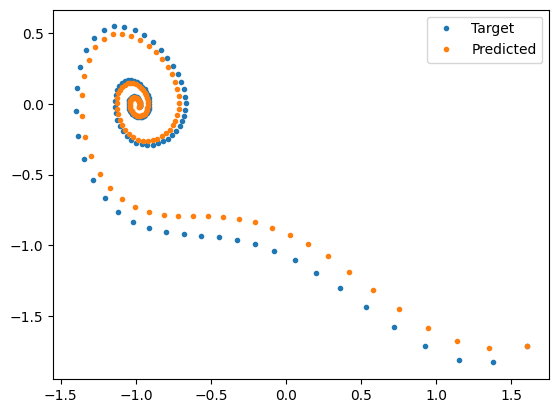

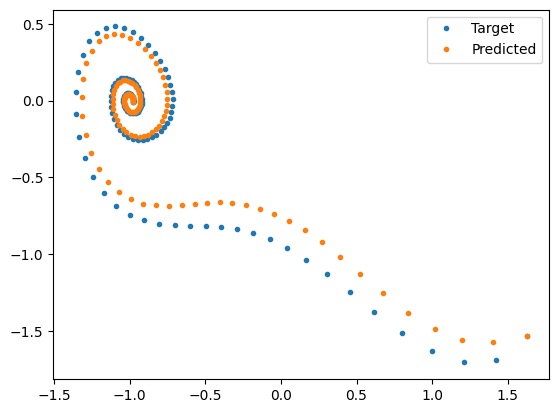

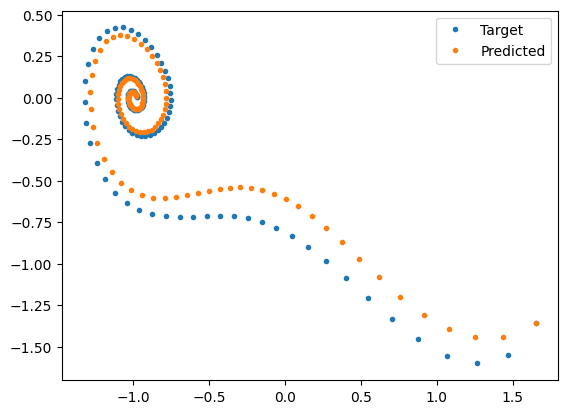

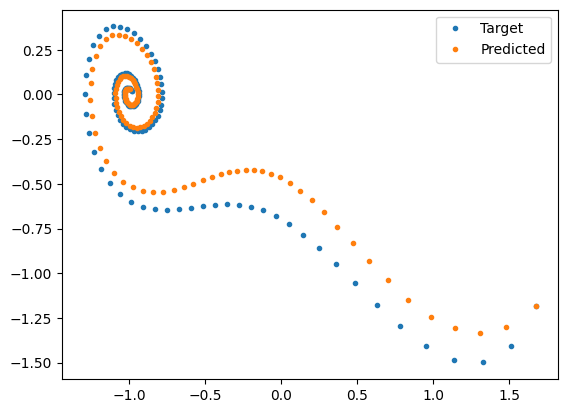

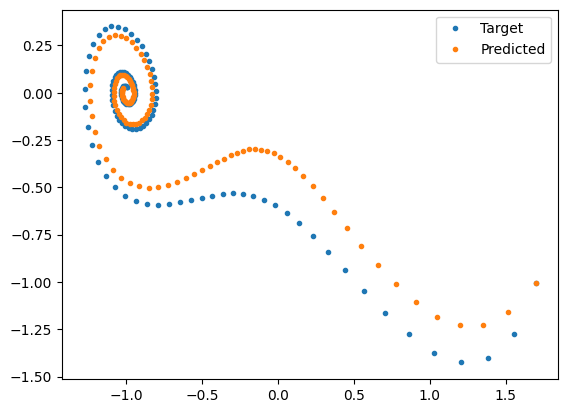

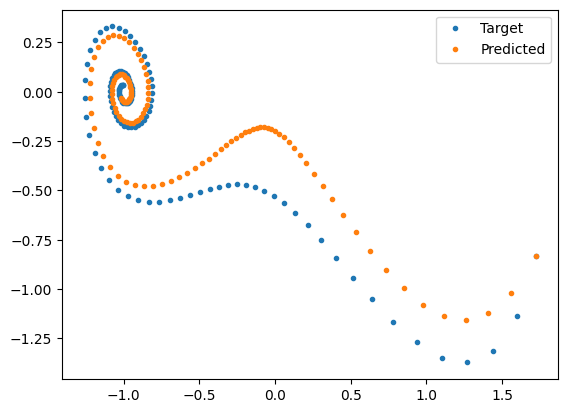

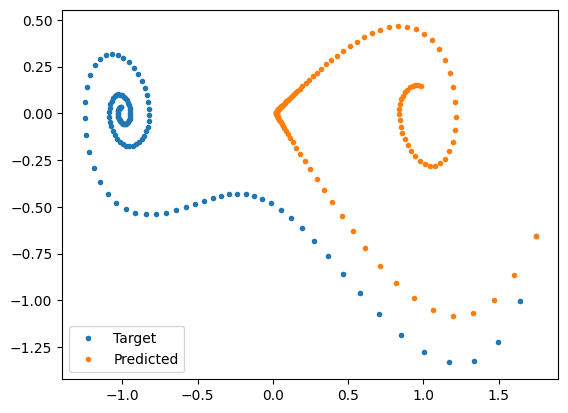

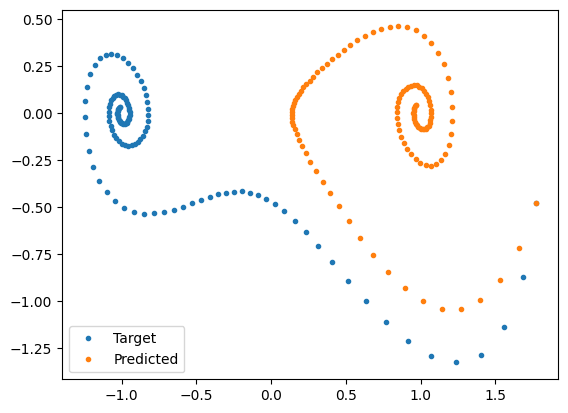

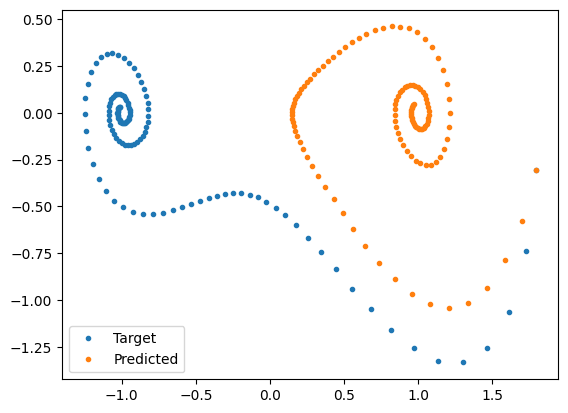

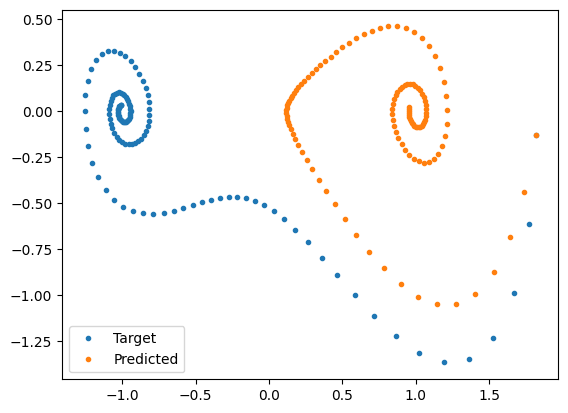

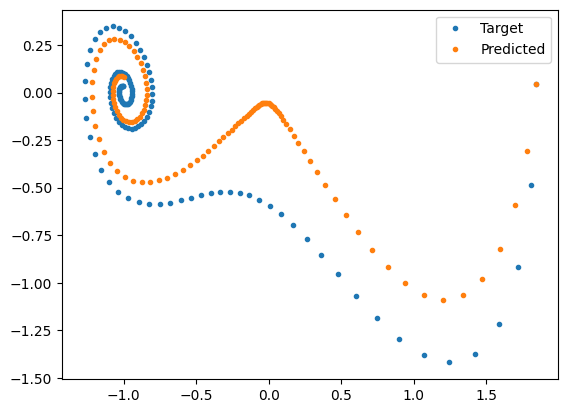

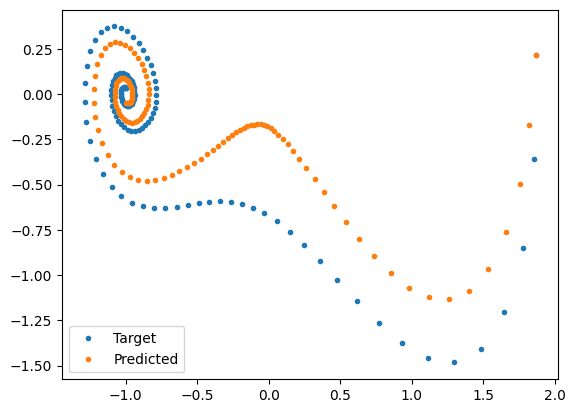

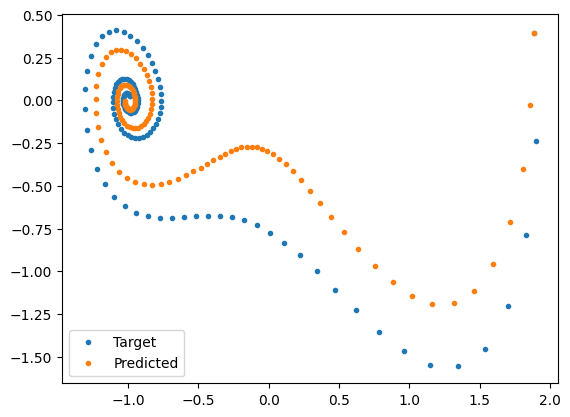

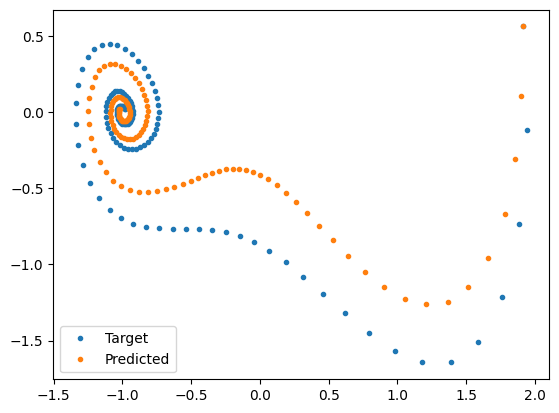

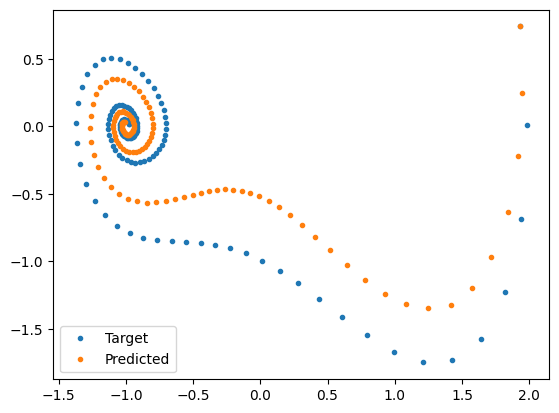

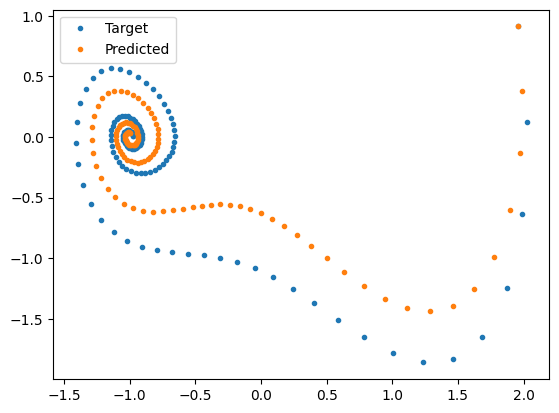

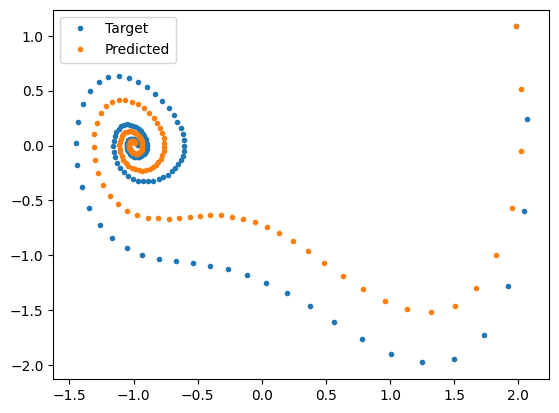

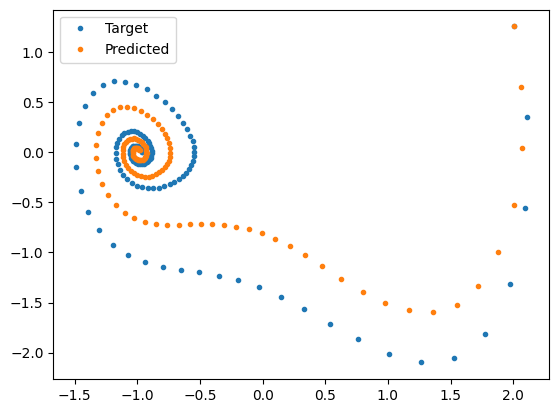

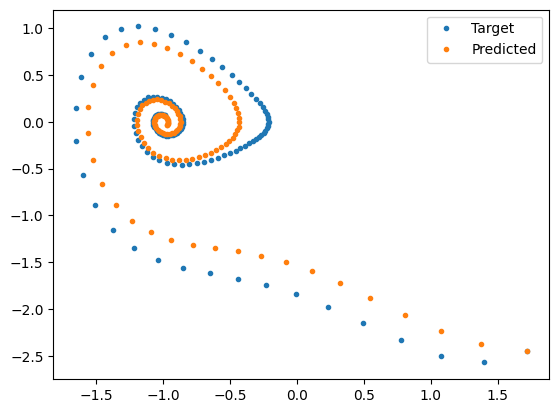

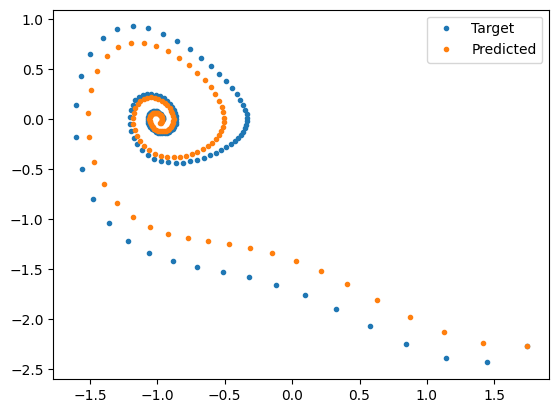

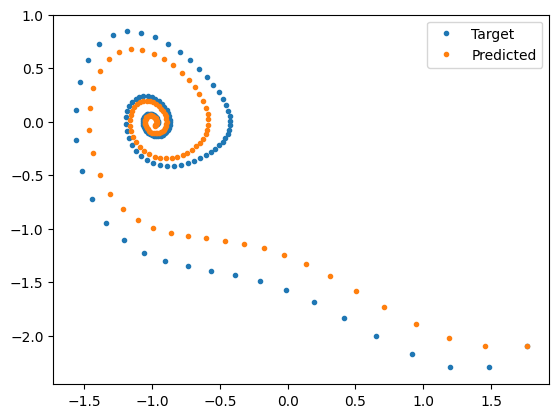

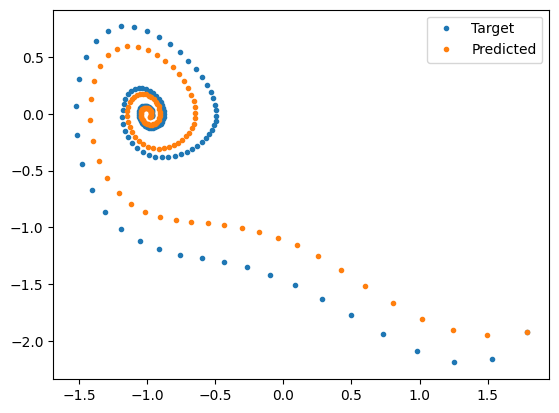

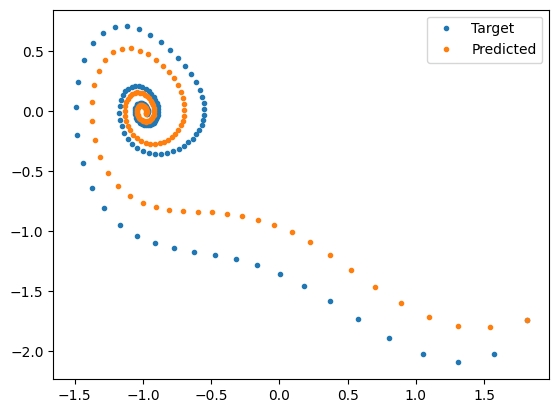

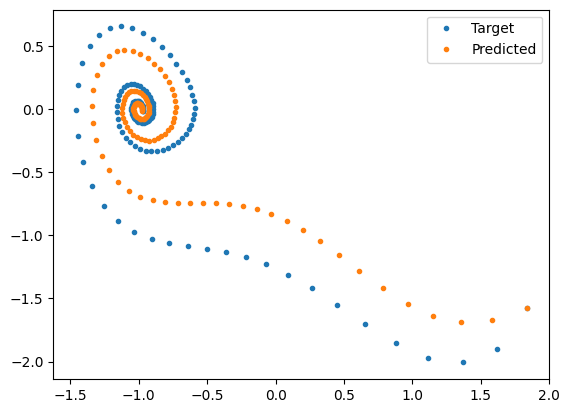

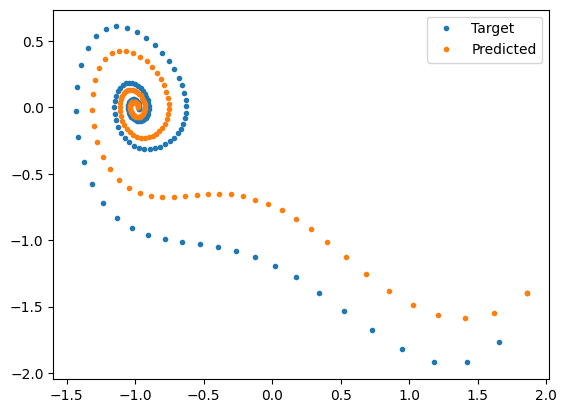

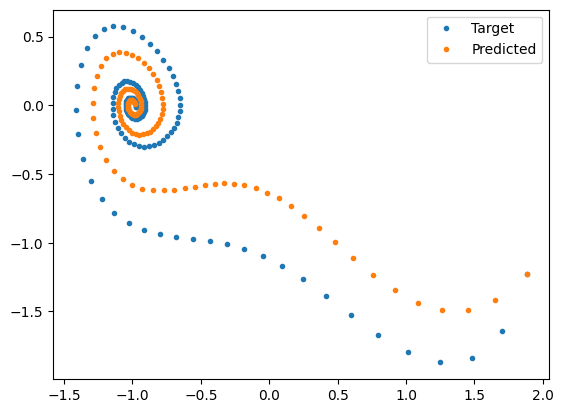

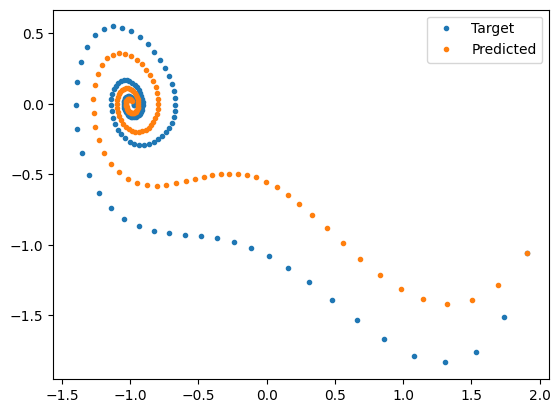

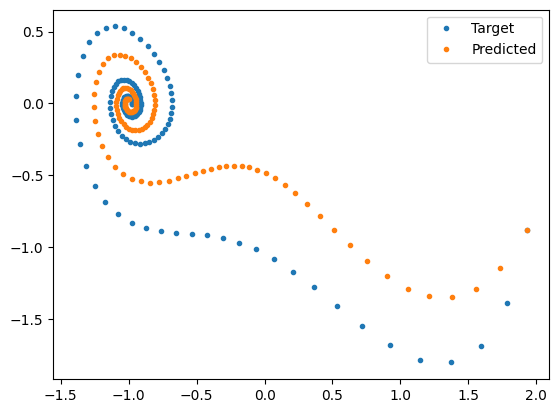

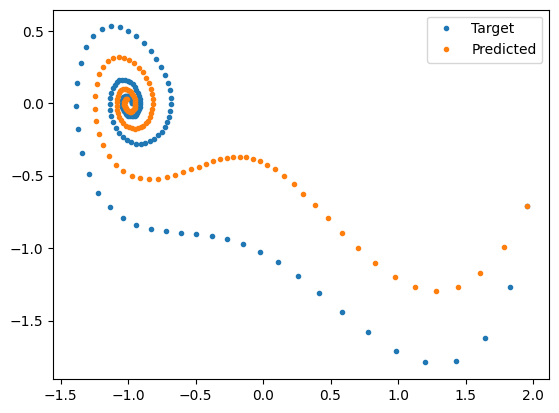

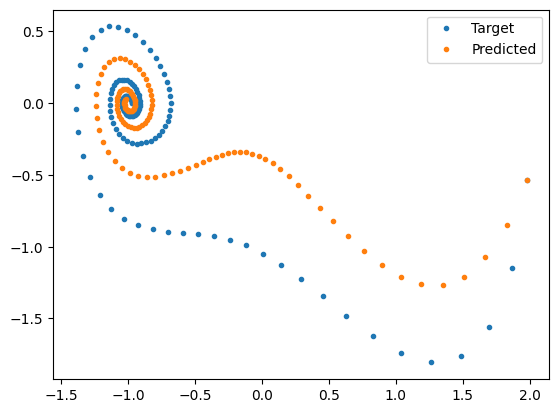

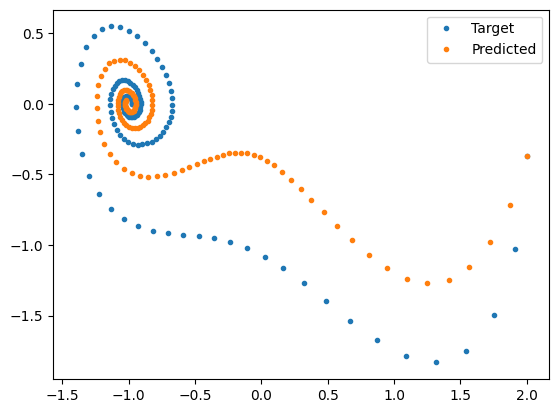

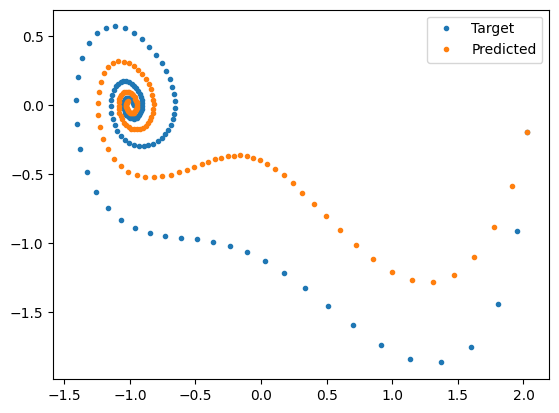

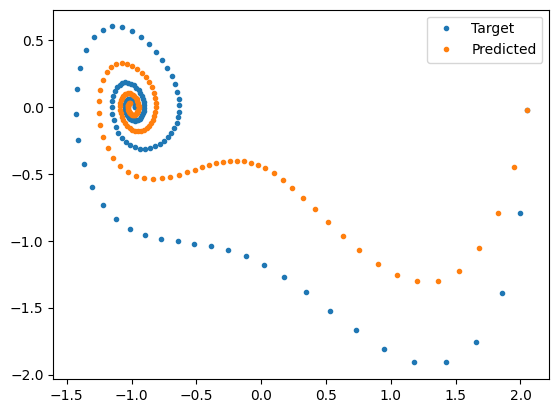

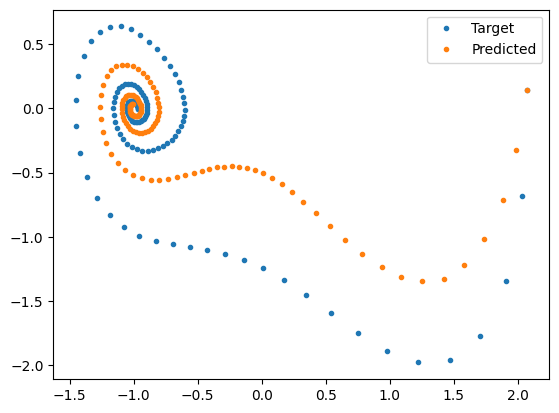

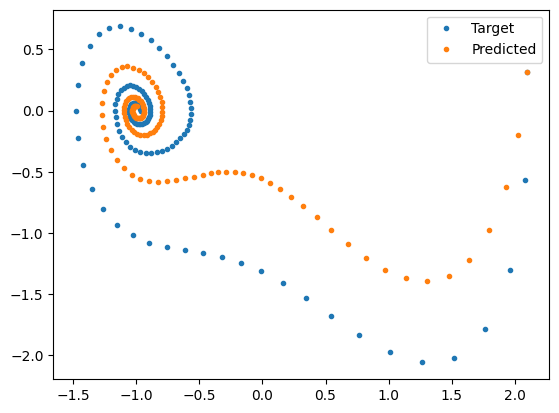

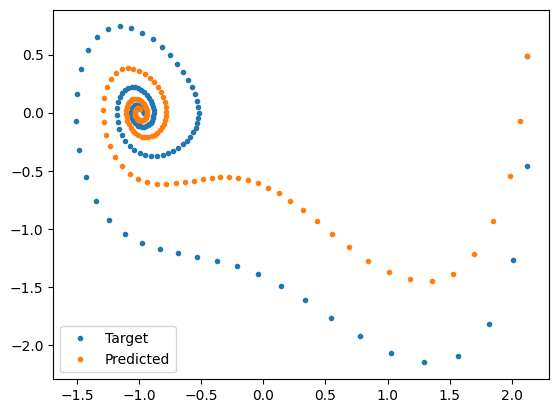

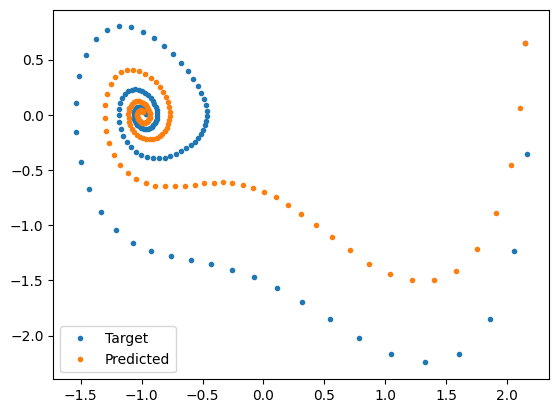

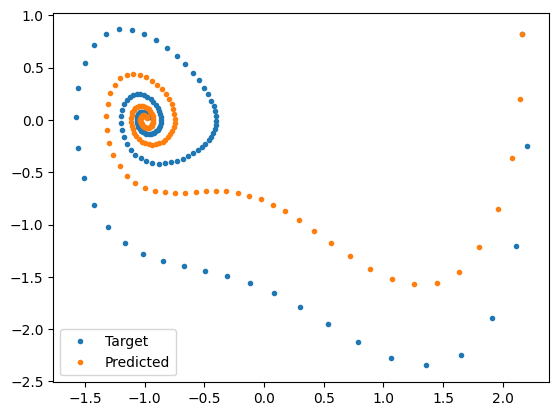

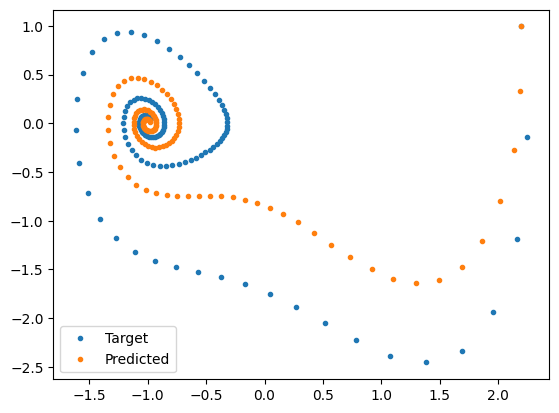

In [18]:
for i in range (89):
    plt.figure()
    plt.plot(re_Phi_nn.cpu().numpy()[:,i,0], re_Phi_nn.cpu().numpy()[:,i,1], '.', label = "Target")
    plt.plot(Phi_hat.detach().cpu().numpy()[i,:,0], Phi_hat.detach().cpu().numpy()[i,:,1], '.', label = "Predicted")
    plt.legend()

Text(0.5, 0, 'Epochs')

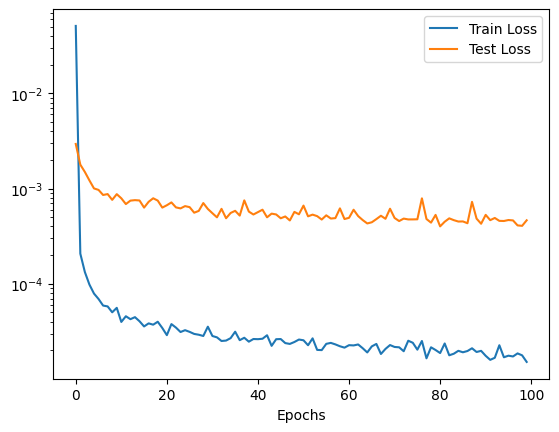

In [11]:
#plot learning curves
df = pd.read_csv(mza.exp_dir+'/'+mza.exp_name+"/out_log/log")

plt.figure()
plt.semilogy(df['epoch'],df['Train_Loss'], label="Train Loss")
plt.semilogy(df['epoch'], df['Test_Loss'], label="Test Loss")
plt.legend()
# plt.savefig(self.exp_dir+'/'+self.exp_name+"/out_log/")
plt.xlabel("Epochs")


Text(0.5, 0, 'Epochs')

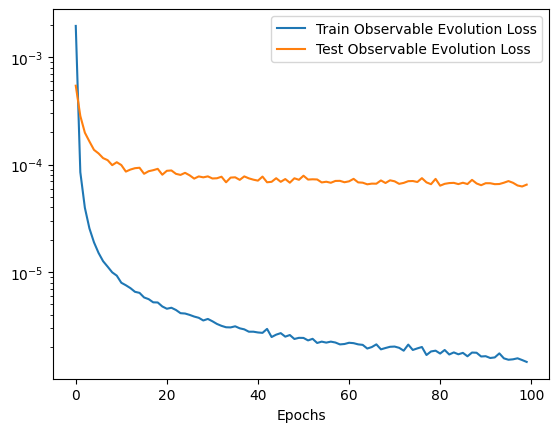

In [12]:
#plot learning curves
# df = pd.read_csv(mza.exp_dir+'/'+mza.exp_name+"/out_log/log")

plt.figure()
plt.semilogy(df['epoch'],df['Train_ObsEvo_Loss'], label="Train Observable Evolution Loss")
plt.semilogy(df['epoch'], df['Test_ObsEvo_Loss'], label="Test Observable Evolution Loss")
plt.legend()
# plt.savefig(self.exp_dir+'/'+self.exp_name+"/out_log/")
plt.xlabel("Epochs")

Text(0.5, 0, 'Epochs')

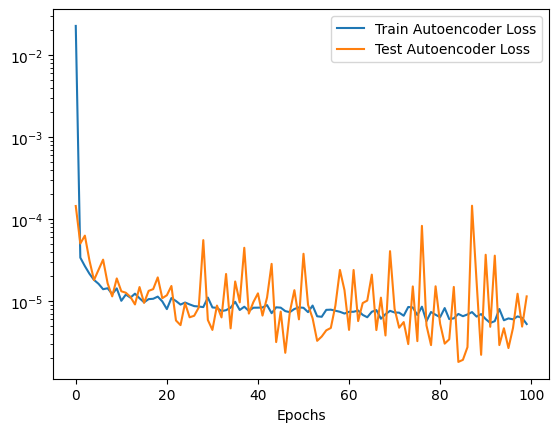

In [13]:
plt.figure()
plt.semilogy(df['epoch'],df['Train_Autoencoder_Loss'], label="Train Autoencoder Loss")
plt.semilogy(df['epoch'], df['Test_Autoencoder_Loss'], label="Test Autoencoder Loss")
plt.legend()
# plt.savefig(self.exp_dir+'/'+self.exp_name+"/out_log/")
plt.xlabel("Epochs")

Text(0.5, 0, 'Epochs')

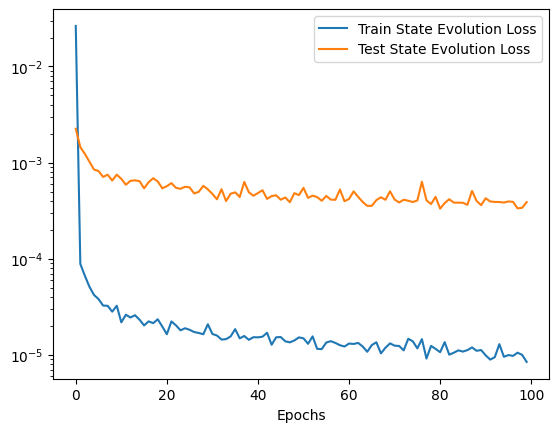

In [14]:
plt.figure()
plt.semilogy(df['epoch'],df['Train_StateEvo_Loss'], label="Train State Evolution Loss")
plt.semilogy(df['epoch'], df['Test_StateEvo_Loss'], label="Test State Evolution Loss")
plt.legend()
# plt.savefig(self.exp_dir+'/'+self.exp_name+"/out_log/")
plt.xlabel("Epochs")

Text(0.5, 0, 'Epochs')

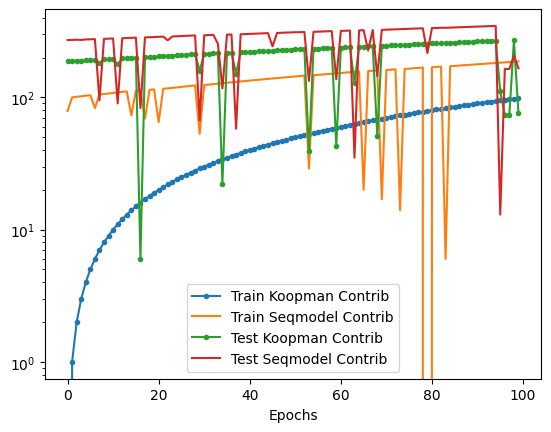

In [15]:
plt.figure()
plt.semilogy(df['epoch'],df['Train_koop_ptg'], '.-',label="Train Koopman Contrib")
plt.semilogy(df['epoch'],df['Train_seqmodel_ptg'], label="Train Seqmodel Contrib")

plt.semilogy(df['epoch'], df['Test_koop_ptg'], '.-',label="Test Koopman Contrib")
plt.semilogy(df['epoch'], df['Test_seqmodel_ptg'], label="Test Seqmodel Contrib")

plt.legend()
# plt.savefig(self.exp_dir+'/'+self.exp_name+"/out_log/")
plt.xlabel("Epochs")

<Figure size 640x480 with 0 Axes>

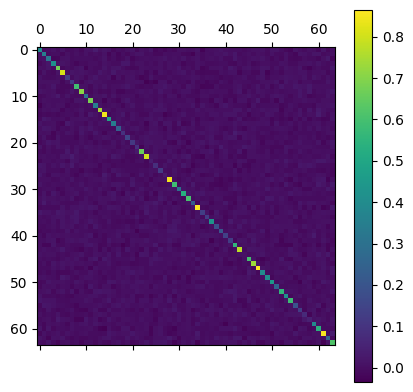

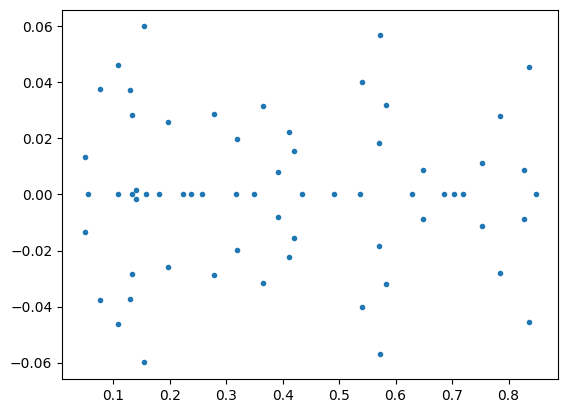

In [29]:
mat = mza.model.koopman.getKoopmanMatrix()
mat = mat.detach().cpu().numpy()
eigval, egivec = np.linalg.eig(mat)

plt.figure()
plt.matshow(mat)
plt.colorbar()

plt.figure()
plt.plot(np.real(eigval), np.imag(eigval), ".")